In [1]:
# Basic python packages
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import matplotlib.pyplot as plt
import glob
import splitfolders

# Packages related to images
from PIL import Image
import PIL


In [22]:
def clean_data(path):
    df = pd.read_csv(path)
    df = df[df['Creator'] != ''] 
    df = df[df['Creator'] != 'anoniem']
    df = df[df['Creator'] != 'onbekend']
    df = df[df['Creator'].notna()]
    df = df.replace('Koning, Cornelis (?-1671)', 'Koning, Cornelis')
    return df

def preprocess_data(df, num_artworks = 10):
    df = df.groupby("Creator").filter(lambda x: len(x) >= num_artworks)
    return df

df = clean_data('../Data/Rijksmuseum/xml_files.csv')
rijksdata = preprocess_data(df, 1100)

In [23]:
rijksdata

,Identifier,Creator,Title,Date,Type
100,RP-T-1905-158(R),"Fokke, Simon","Jonge edelman, naar links in gebogen houding",1710 - 1779,tekening
101,RP-T-1905-158(V),"Fokke, Simon",Zittende man,ca. 1710 - ca. 1779,tekening
2275,SK-C-5,Rembrandt Harmensz. van Rijn,Officieren en andere schutters van wijk II in ...,1642 - 1642,schilderij
2276,SK-C-6,Rembrandt Harmensz. van Rijn,De Staalmeesters: het college van staalmeester...,1662 - 1662,schilderij
2277,SK-A-3340,Rembrandt Harmensz. van Rijn,Borstbeeld van een man in oosterse kleding (),1635 - 1635,schilderij
...,...,...,...,...,...
111753,RP-P-OB-102.936,"Picart, Bernard",Elegant gezelschap speelt het kaartspel Jeu de...,1709 - 1709,prent
111754,RP-P-OB-51.369X,"Picart, Bernard",Allegorische voorstelling met liefdesparen,1721 - 1721,prent
111788,RP-P-1896-A-19368-1738,"Luyken, Jan",Vroeg-christelijke gemeenschap luistert naar e...,1700 - 1700,prent
111816,RP-P-1896-A-19368-1436(V),"Luyken, Jan",Hollandse troepen bestormen de muur van Tienen...,1698 - 1698,prent


In [24]:
#Paths to different folders/files
img_list = glob.glob("../Data/Rijksmuseum/jpg2/*.jpg")
image_dir = "../Data/Rijksmuseum/jpg2/"
split_image_dir = "../Data/Rijksmuseum/jpg2_split_1100/"

n_labels = len(rijksdata.groupby('Creator').count())

In [25]:
n_labels

6

In [26]:
# labels = pd.read_csv(labels_file)
labels = rijksdata[['Identifier', 'Creator']]
labels

,Identifier,Creator
100,RP-T-1905-158(R),"Fokke, Simon"
101,RP-T-1905-158(V),"Fokke, Simon"
2275,SK-C-5,Rembrandt Harmensz. van Rijn
2276,SK-C-6,Rembrandt Harmensz. van Rijn
2277,SK-A-3340,Rembrandt Harmensz. van Rijn
...,...,...
111753,RP-P-OB-102.936,"Picart, Bernard"
111754,RP-P-OB-51.369X,"Picart, Bernard"
111788,RP-P-1896-A-19368-1738,"Luyken, Jan"
111816,RP-P-1896-A-19368-1436(V),"Luyken, Jan"


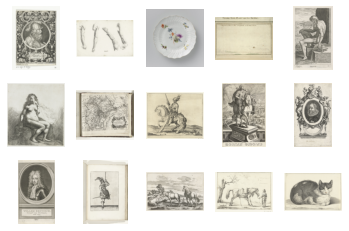

In [7]:
def plot_random_images(img_names, n_x=2, n_y=2, seed=0):
    """
    Plots random images from de data set in a n_x by n_y grid

    :image_names: List with the names of all images
    :n_x: Height of the grid
    :n_x: Width of the grid
    :seed: Seed for the random sample
    :return: nothing
    """ 
    f, axs = plt.subplots(n_x, n_y)
    sample = img_names.sample(n_x * n_y, random_state=seed)
    c = 0
    for x in range(n_x):
        for y in range(n_y):
            img_loc = [item for item in img_list if sample.iloc[c] in item][0]
            img = plt.imread(img_loc)
            axs[x, y].imshow(img)
            axs[x, y].axis('off')
            c += 1

plot_random_images(labels["Identifier"], 3, 5)

In [8]:
labels['Creator'].iloc[0]

'Coornhert, Dirck Volckertsz'

# Reformat data for learning
To be able to load the data with a generator. We must split the training and validation data and place them into a folder based on their label.

In [27]:
def generate_label_folders(image_path, image_names, image_labels, destination_path):
    """
    Splits a single folder with images into multiple folders where images are placed based on their labels.

    :image_path: path to the folder with the images
    :image_names: A numpy array with the names of all images
    :image_labels: A numpy array with the labels of all images
    :destination_path: Path of the folder where the images are placed into
    :return: Nothing
    """ 
    for i in range(len(image_names)):
        if i % 83 == 0:
            print(str(round(i/len(image_names)*100, 1)) + '%')
            
        # Check if the directory exists. Else, make one
        isExist = os.path.exists(os.path.join(destination_path, str(image_labels.iloc[i])))
        if not isExist:
            os.makedirs(os.path.join(destination_path, str(image_labels.iloc[i])))
            
        # Copy the image
        img_loc = [item for item in img_list if image_names.iloc[i] in item][0]
        img = Image.open(img_loc)
        img.save(destination_path + "/" + str(image_labels.iloc[i]) + "/" + image_names.iloc[i] + ".jpg")
        

generate_label_folders(image_dir, labels["Identifier"], labels["Creator"], split_image_dir)

0.0%
1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
8.9%
9.9%
10.9%
11.9%
12.9%
13.9%
14.9%
15.9%
16.9%
17.9%
18.9%
19.9%
20.9%
21.9%
22.9%
23.9%
24.9%
25.8%
26.8%
27.8%
28.8%
29.8%
30.8%
31.8%
32.8%
33.8%
34.8%
35.8%
36.8%
37.8%
38.8%
39.8%
40.8%
41.7%
42.7%
43.7%
44.7%
45.7%
46.7%
47.7%
48.7%
49.7%
50.7%
51.7%
52.7%
53.7%
54.7%
55.7%
56.7%
57.7%
58.6%
59.6%
60.6%
61.6%
62.6%
63.6%
64.6%
65.6%
66.6%
67.6%
68.6%
69.6%
70.6%
71.6%
72.6%
73.6%
74.6%
75.5%
76.5%
77.5%
78.5%
79.5%
80.5%
81.5%
82.5%
83.5%
84.5%
85.5%
86.5%
87.5%
88.5%
89.5%
90.5%
91.4%
92.4%
93.4%
94.4%
95.4%
96.4%
97.4%
98.4%
99.4%


In [28]:
splitfolders.ratio(split_image_dir, output="output_1100", seed=1337, ratio=(.7, .1, .2)) 

Copying files: 8350 files [00:23, 349.23 files/s]
